## 0. Imports, Config, and Loading dataset

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from utils.early_stopping import CustomEarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import mlflow
mlflow.tensorflow.autolog()
mlflow.set_experiment('baseline_neural_network')

<Experiment: artifact_location='s3://infnet-mlflow-bucket/1', creation_time=1758497837088, experiment_id='1', last_update_time=1758497837088, lifecycle_stage='active', name='baseline_neural_network', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [3]:
# config so we can easily change
balance_treatment_type = 'oversampling' # 'undersampling', or 'oversampling'
target_col = 'diabetes'
random_state = 42
dataset_test_size = 0.2
learning_rate = 0.01
epochs = 200
batch_size = 256
loss_function = 'binary_crossentropy' # 'binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy', 'mse', 'mae', 'hinge'
metrics = ['recall'] # 'accuracy', 'precision', 'recall', 'f1_score'
n_neurons = 5
activation_function = 'relu'
optimizer_type = 'adam'  # 'adam', 'sgd', 'rmsprop'

# Early stopping configuration
early_stopping_patience = 20 # number of epochs to wait before stopping the training
min_improvement = 0.02 # should improve at least 2% in the validation loss to continue training
early_stopping_monitor = 'recall'


In [4]:
file_name = "diabetes_prediction_dataset.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "iammustafatz/diabetes-prediction-dataset",
    file_name,
)

If you want to see details about exploratory data analysis, please take a look in the file [exploratory_data_analysis.ipynb](exploratory_data_analysis.ipynb) instead, because this file will be focused in get a baselines model.

## 1. Cleaning the dataset

In [5]:
df.isnull().sum() # we don't have null values in the dataset, so we don't need to handle them

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
# Convert the column "blood_glucose_level" to float
df['blood_glucose_level'] = df['blood_glucose_level'].astype(float)

In [7]:
# Transform feature gender in binary (Male == 1, Female = 0)
def is_male(gender: str):
    return 1 if gender.strip().lower() == 'male' else 0
df['gender'] = df['gender'].map(is_male)

In [8]:
# Convert the info smoking_history in information if the patient is a smoker or not (binary) 
df['is_smoker'] = df['smoking_history'].map({'never': 0, 'No Info': 0, 'current': 1, 'former': 1, 'ever': 1, 'not current': 0})
# Remove the column "age" from the dataset
df = df.drop(columns=['smoking_history'])

In [9]:
df

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,is_smoker
0,0,80.0,0,1,25.19,6.6,140.0,0,0
1,0,54.0,0,0,27.32,6.6,80.0,0,0
2,1,28.0,0,0,27.32,5.7,158.0,0,0
3,0,36.0,0,0,23.45,5.0,155.0,0,1
4,1,76.0,1,1,20.14,4.8,155.0,0,1
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,27.32,6.2,90.0,0,0
99996,0,2.0,0,0,17.37,6.5,100.0,0,0
99997,1,66.0,0,0,27.83,5.7,155.0,0,1
99998,0,24.0,0,0,35.42,4.0,100.0,0,0


In [10]:
df.dtypes # all the data is in the correct format to proceed with the model

gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level    float64
diabetes                 int64
is_smoker                int64
dtype: object

## 2. Normalizing the features

In [11]:
# Apply normalization to the continuous features to improve the model performance
continuous_features = ['age', 'blood_glucose_level', 'bmi', 'HbA1c_level']

scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [12]:
df[continuous_features].describe() # normalization was applied correctly

,age,blood_glucose_level,bmi,HbA1c_level
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,1.447553e-16,-2.786749e-16,-1.729816e-16,-3.410605e-18
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.856658e+00,-1.426210e+00,-2.608320e+00,-1.893686e+00
25%,-7.943364e-01,-9.349053e-01,-5.561106e-01,-6.794897e-01
50%,4.948073e-02,4.770422e-02,-1.155837e-04,2.545078e-01
75%,8.044750e-01,5.144437e-01,3.404125e-01,6.281067e-01
max,1.692704e+00,3.978142e+00,1.030161e+01,3.243300e+00


## 3. Treating the desbalanceament

In [13]:
def apply_undersampling(df: pd.DataFrame) -> pd.DataFrame:
    # separate the classes
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    # undersample the majority class
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=random_state
    )
    
    # combine the downsampled majority class with the minority class and return the new balanced dataset
    return pd.concat([df_majority_downsampled, df_minority])

def apply_oversampling(df: pd.DataFrame) -> pd.DataFrame:
    # separate the classes
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    # oversample the minority class
    df_minority_oversampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=random_state
    )
    
    # combine the oversampled minority class with the majority class and return the new balanced dataset
    return pd.concat([df_majority, df_minority_oversampled])
    
if balance_treatment_type == 'undersampling':
    df = apply_undersampling(df)
elif balance_treatment_type == 'oversampling':
    df = apply_oversampling(df)
else:
    raise ValueError(f"Invalid balance treatment type: {balance_treatment_type}")

In [14]:
print('Number of diabetes 0: ', df[target_col].value_counts()[0])
print('Number of diabetes 1: ', df[target_col].value_counts()[1])

Number of diabetes 0:  91500
Number of diabetes 1:  91500


In [15]:
# Separate features and target
X = df.drop(columns=[target_col], axis=1)
y = df[target_col]

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=dataset_test_size, random_state=random_state)

## 5. Creating Baseline Neural Network

In [16]:
# Define the optimizer
optimizer = 0
if optimizer_type == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
elif optimizer_type == 'sgd':
    optimizer = SGD(learning_rate=learning_rate)
elif optimizer_type == 'rmsprop':
    optimizer = RMSprop(learning_rate=learning_rate)
else:
    raise ValueError(f"Invalid optimizer type: {optimizer_type}")

In [17]:
# Create the model with the number of neurons in the input layer
model = Sequential([
    Dense(n_neurons, activation=activation_function, input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

# Compile the model with the optimizer, loss function and metrics
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics
)

/Users/alexandrelara/Documents/storage/c/code/diabetes_neural_network/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Early stopping callback
early_stopping = CustomEarlyStopping(
    monitor=early_stopping_monitor,
    min_improvement=min_improvement,
    patience=early_stopping_patience
)

# Train the model
with mlflow.start_run() as run:
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

2025/09/22 19:45:48 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


2025/09/22 19:45:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: No module named 'boto3'


Epoch 1/200
445/572 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 0.5127 - recall: 0.7977Epoch 1: ✅ Improvement detected! recall: 0.8704 (best: 0.8704)


2025/09/22 19:45:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3257 - recall: 0.8704  
Epoch 2/200
483/572 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - loss: 0.2523 - recall: 0.8776Epoch 2: ❌ Insufficient improvement. recall: 0.8795 (needs: 0.8904) Wait: 1/20


2025/09/22 19:45:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2507 - recall: 0.8795  
Epoch 3/200
468/572 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 0.2488 - recall: 0.8817Epoch 3: ❌ Insufficient improvement. recall: 0.8809 (needs: 0.8904) Wait: 2/20


2025/09/22 19:45:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2491 - recall: 0.8809  
Epoch 4/200
568/572 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.2483 - recall: 0.8809Epoch 4: ❌ Insufficient improvement. recall: 0.8817 (needs: 0.8904) Wait: 3/20


2025/09/22 19:45:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2482 - recall: 0.8817  
Epoch 5/200
485/572 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 0.2492 - recall: 0.8812Epoch 5: ❌ Insufficient improvement. recall: 0.8824 (needs: 0.8904) Wait: 4/20


2025/09/22 19:45:52 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2476 - recall: 0.8824  
Epoch 6/200
459/572 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 0.2450 - recall: 0.8830Epoch 6: ❌ Insufficient improvement. recall: 0.8879 (needs: 0.8904) Wait: 5/20


2025/09/22 19:45:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2420 - recall: 0.8879  
Epoch 7/200
467/572 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 0.2367 - recall: 0.8912Epoch 7: ✅ Improvement detected! recall: 0.8915 (best: 0.8915)


2025/09/22 19:45:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2392 - recall: 0.8915  
Epoch 8/200
465/572 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 0.2378 - recall: 0.8921Epoch 8: ❌ Insufficient improvement. recall: 0.8932 (needs: 0.9115) Wait: 1/20


2025/09/22 19:45:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2381 - recall: 0.8932  
Epoch 9/200
432/572 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.2349 - recall: 0.8943Epoch 9: ❌ Insufficient improvement. recall: 0.8920 (needs: 0.9115) Wait: 2/20


2025/09/22 19:45:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2364 - recall: 0.8920  
Epoch 10/200
476/572 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.2276 - recall: 0.8961Epoch 10: ❌ Insufficient improvement. recall: 0.8957 (needs: 0.9115) Wait: 3/20


2025/09/22 19:45:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2273 - recall: 0.8957  
Epoch 11/200
449/572 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 0.2206 - recall: 0.8978Epoch 11: ❌ Insufficient improvement. recall: 0.8970 (needs: 0.9115) Wait: 4/20


2025/09/22 19:45:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2205 - recall: 0.8970  
Epoch 12/200
468/572 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 0.2208 - recall: 0.8943Epoch 12: ❌ Insufficient improvement. recall: 0.8960 (needs: 0.9115) Wait: 5/20


2025/09/22 19:45:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2183 - recall: 0.8960  
Epoch 13/200
449/572 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 0.2185 - recall: 0.8939Epoch 13: ❌ Insufficient improvement. recall: 0.8956 (needs: 0.9115) Wait: 6/20


2025/09/22 19:45:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2176 - recall: 0.8956  
Epoch 14/200
436/572 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 0.2177 - recall: 0.8975Epoch 14: ❌ Insufficient improvement. recall: 0.8962 (needs: 0.9115) Wait: 7/20


2025/09/22 19:45:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2169 - recall: 0.8962  
Epoch 15/200
471/572 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 0.2146 - recall: 0.8962Epoch 15: ❌ Insufficient improvement. recall: 0.8953 (needs: 0.9115) Wait: 8/20


2025/09/22 19:46:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2167 - recall: 0.8953  
Epoch 16/200
469/572 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 0.2162 - recall: 0.8973Epoch 16: ❌ Insufficient improvement. recall: 0.8963 (needs: 0.9115) Wait: 9/20


2025/09/22 19:46:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2171 - recall: 0.8963  
Epoch 17/200
461/572 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 0.2153 - recall: 0.8978Epoch 17: ❌ Insufficient improvement. recall: 0.8966 (needs: 0.9115) Wait: 10/20


2025/09/22 19:46:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2166 - recall: 0.8966  
Epoch 18/200
464/572 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 0.2164 - recall: 0.8957Epoch 18: ❌ Insufficient improvement. recall: 0.8965 (needs: 0.9115) Wait: 11/20


2025/09/22 19:46:02 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2165 - recall: 0.8965  
Epoch 19/200
448/572 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 0.2165 - recall: 0.8968Epoch 19: ❌ Insufficient improvement. recall: 0.8963 (needs: 0.9115) Wait: 12/20


2025/09/22 19:46:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2165 - recall: 0.8963  
Epoch 20/200
461/572 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 0.2183 - recall: 0.8954Epoch 20: ❌ Insufficient improvement. recall: 0.8957 (needs: 0.9115) Wait: 13/20


2025/09/22 19:46:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2164 - recall: 0.8957  
Epoch 21/200
467/572 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 0.2169 - recall: 0.8944Epoch 21: ❌ Insufficient improvement. recall: 0.8960 (needs: 0.9115) Wait: 14/20


2025/09/22 19:46:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2158 - recall: 0.8960  
Epoch 22/200
555/572 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 0.2165 - recall: 0.8962Epoch 22: ❌ Insufficient improvement. recall: 0.8968 (needs: 0.9115) Wait: 15/20


2025/09/22 19:46:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2158 - recall: 0.8968  
Epoch 23/200
459/572 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 0.2161 - recall: 0.8941Epoch 23: ❌ Insufficient improvement. recall: 0.8953 (needs: 0.9115) Wait: 16/20


2025/09/22 19:46:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2159 - recall: 0.8953  
Epoch 24/200
462/572 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 0.2154 - recall: 0.8972Epoch 24: ❌ Insufficient improvement. recall: 0.8961 (needs: 0.9115) Wait: 17/20


2025/09/22 19:46:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2153 - recall: 0.8961  
Epoch 25/200
431/572 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.2158 - recall: 0.8973Epoch 25: ❌ Insufficient improvement. recall: 0.8967 (needs: 0.9115) Wait: 18/20


2025/09/22 19:46:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2151 - recall: 0.8967  
Epoch 26/200
445/572 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 0.2149 - recall: 0.8951Epoch 26: ❌ Insufficient improvement. recall: 0.8958 (needs: 0.9115) Wait: 19/20


2025/09/22 19:46:08 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2155 - recall: 0.8958  
Epoch 27/200
469/572 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 0.2151 - recall: 0.8959Epoch 27: ❌ Insufficient improvement. recall: 0.8970 (needs: 0.9115) Wait: 20/20

🛑 Early Stopping! Stopped at epoch 27
Best recall: 0.8915


2025/09/22 19:46:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2150 - recall: 0.8970  


2025/09/22 19:46:09 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/09/22 19:46:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/22 19:46:10 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/09/22 19:46:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec wi

🏃 View run abundant-shrimp-226 at: http://54.85.131.89:5000/#/experiments/1/runs/28c99bef1d3940628e05a5fc21fc3f57
🧪 View experiment at: http://54.85.131.89:5000/#/experiments/1


## 6. Analyzing the Baseline neural network metrics

In [19]:
accuracy = history.history['recall'][-1]
print(f"Recall: {(accuracy * 100):.2f}%")

Recall: 89.70%


In [20]:
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

1144/1144 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step


In [21]:
cm = confusion_matrix(y_test, predicted_classes)

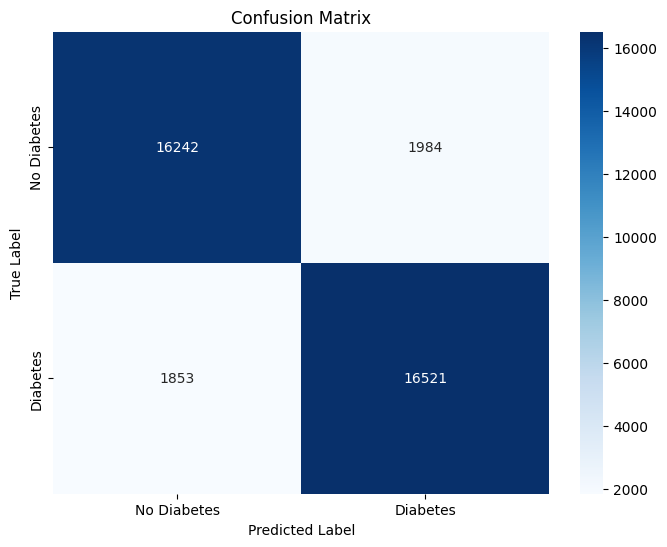

In [22]:
# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [23]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

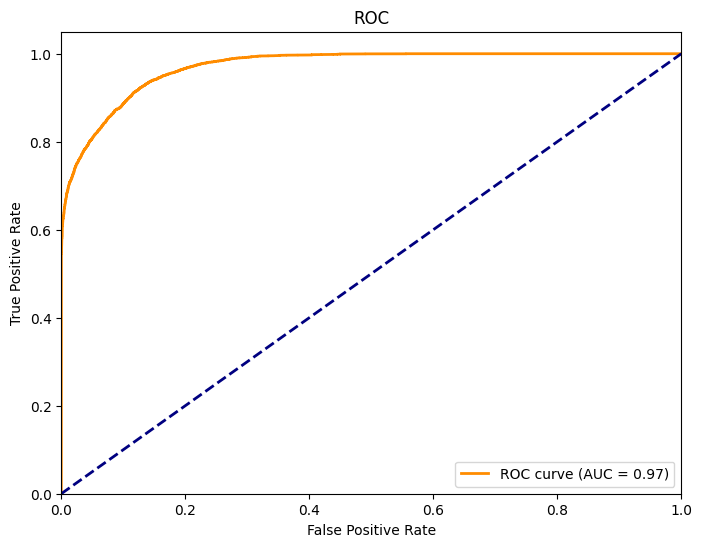

In [24]:
# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()